In [2]:
from PIL import Image
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

dataRep = '../data/'
datasetRep = '../data/dataset/'
trainImageRep = '../data/train_images/'
scriptRep = '../'

#Import the scripts
import sys
sys.path.insert(1, os.path.abspath(scriptRep))
import kuzushiji_recognition as kr

unicodeData = pd.read_csv(dataRep+'unicode_translation.csv')
trainData = pd.read_csv(dataRep+'train.csv')
sampleSubData = pd.read_csv(dataRep+'sample_submission.csv')

In [3]:
#Parameters Cell

nbImageTrain = 100
xpixel = 512
ypixel = 512
minSize=32
fill_color=(255, 255, 255)

In [4]:
#Creation of the dataset

imagesId = trainData.image_id.tolist()
labels = trainData.labels.tolist()
poulpe = list(zip(imagesId,labels))
#print(imagesId)
imageTrain = random.choices(poulpe, weights=None, cum_weights=None, k=nbImageTrain)
trainImagesId, trainLabel = list(zip(*imageTrain))
#print(trainImagesId[0])

In [15]:
#Creation of the training segmentation maps
segMaps = np.zeros((nbImageTrain, xpixel, ypixel, 2))

for i in range(nbImageTrain):
    Im = Image.open(trainImageRep + trainImagesId[i] + '.jpg')
    xIm, yIm = Im.size
    dB = kr.createCaracDatabase(trainLabel[i], unicodeData)
    segMap = kr.createSegmentationMap(xIm, yIm, dB)
    segMapCenter = kr.createSegmentationCenterMap(xIm, yIm, dB, (5,5))
    cSegMap = kr.convertImage(Image.fromarray(segMap), xpixel, ypixel, gray=True, squared=True)
    cSegMapCenter = kr.convertImage(Image.fromarray(segMapCenter), xpixel, ypixel, gray=True, squared=True)
    cSegMap = (np.sum(np.array(cSegMap), axis=2)/3.).astype(np.uint8)
    cSegMapCenter = (np.sum(np.array(cSegMapCenter), axis=2)/3.).astype(np.uint8)
    cSegMaps = np.swapaxes(np.array([cSegMap,cSegMapCenter],dtype=np.uint8), 0, 2)
    segMaps[i] = cSegMaps
    
#     fig, ax = plt.subplots(1,3, figsize=(20,20))
#     ax1, ax2, ax3 = ax.ravel()
#     ax1.imshow(Im)
#     ax2.imshow(segMapCenter)
#     ax3.imshow(cSegMapCenter)
#     plt.tight_layout()

In [ ]:
#Creation of the U-Net for segmentation maps

def createModelUNet(dropoutRate, convLayer, denseLayer):
    inputs = Input(, name='input')
    #1st Stage
    conv1a = Conv2D(convLayer, (3, 3), activation='relu', name='conv1a')(inputs)
    drop1a = SpatialDropout2D(dropoutRate, name='drop1a')(conv1a)
    conv1b = Conv2D(convLayer, (3, 3), activation='relu', padding='same', name='conv1b')(drop1a)
    drop1b = SpatialDropout2D(dropoutRate, name='drop1b')(conv1b)
    pool1 = MaxPooling2D(pool_size=(2, 2), name='pool1')(drop1b)
    
    #2nd Stage
    conv2a = Conv2D(convLayer*2, (3, 3), activation='relu', name='conv2a')(pool1)
    drop2a = SpatialDropout2D(dropoutRate, name='drop2a')(conv2a)
    conv2b = Conv2D(convLayer*2, (3, 3), activation='relu', name='conv2b')(drop2a)
    drop2b = SpatialDropout2D(dropoutRate, name='drop2b')(conv2b)
    pool2 = MaxPooling2D(pool_size=(2, 2), name='pool2')(drop2b)
    
    #3rd Stage
    conv3a = Conv2D(convLayer*4, (3, 3), activation='relu', name='conv3a')(pool2)
    drop3a = SpatialDropout2D(dropoutRate, name='drop3a')(conv3a)
    conv3b = Conv2D(convLayer*4, (3, 3), activation='relu', name='conv3b')(drop3a)
    drop3b = SpatialDropout2D(dropoutRate, name='drop3b')(conv3b)
    pool3 = MaxPooling2D(pool_size=(2, 2), name='pool3')(drop3b)
    
    #4th Stage
    conv4a = Conv2D(convLayer*8, (3, 3), activation='relu', name='conv4a')(pool3)
    drop4a = SpatialDropout2D(dropoutRate, name='drop4a')(conv4a)
    conv4b = Conv2D(convLayer*8, (3, 3), activation='relu', name='conv4b')(drop4a)
    drop4b = SpatialDropout2D(dropoutRate, name='drop4b')(conv4b)
    pool4 = MaxPooling2D(pool_size=(2, 2), name='pool4')(drop4b)
    
    #5th Stage
    conv5a = Conv2D(convLayer*16, (3, 3), activation='relu', name='conv5a')(pool4)
    drop5a = SpatialDropout2D(dropoutRate, name='drop5a')(conv5a)
    conv5b = Conv2D(convLayer*16, (3, 3), activation='relu', name='conv5b')(drop5a)
    drop5b = SpatialDropout2D(dropoutRate, name='drop5b')(conv5b)
    
    #6th Stage
    up6 = Conv2DTranspose(convLayerr*8, (3, 3), activation='relu', name='conv6a')(drop5b)
    merge6 = concatenate([drop4b, up6], axis=3, name='merge6')
    conv6b = Conv2D(convLayer*8, (3, 3), activation='relu', name='conv6b')(merge6)
    drop6b = SpatialDropout2D(dropoutRate, name='drop6b')(conv6b)
    conv6c = Conv2D(convLayer*8, (3, 3), activation='relu', name='conv6c')(drop6b)
    drop6c = SpatialDropout2D(dropoutRate, name='drop6c')(conv6c)
    
    #7th Stage
    up7 = Conv2DTranspose(convLayer*4, (3, 3), activation='relu', name='conv7a')(drop6c)
    merge7 = concatenate([drop3b, up7], axis=3, name='merge7')
    conv7b = Conv2D(convLayer*4, (3, 3), activation='relu', name='conv7b')(merge7)
    drop7b = SpatialDropout2D(dropoutRate, name='drop7b')(conv7b)
    conv7c = Conv2D(convLayer*4, (3, 3), activation='relu', name='conv7c')(drop7b)
    drop7c = SpatialDropout2D(dropoutRate, name='drop7c')(conv7c)
    
    #8th Stage
    up8 = Conv2DTranspose(convLayerr*2, (3, 3), activation='relu', name='conv8a')(drop7c)
    merge8 = concatenate([drop2b, up8], axis=3, name='merge8')
    conv8b = Conv2D(convLayer*2, (3, 3), activation='relu', name='conv8b')(merge8)
    drop8b = SpatialDropout2D(dropoutRate, name='drop8b')(conv8b)
    conv8c = Conv2D(convLayer*2, (3, 3), activation='relu', name='conv8c')(drop8b)
    drop8c = SpatialDropout2D(dropoutRate, name='drop8c')(conv8c)
    
    #9th Stage
    up9 = Conv2DTranspose(convLayer, (3, 3), activation='relu', name='conv9a')(drop8c)
    merge9 = concatenate([drop1b, up9], axis=3, name='merge9')
    conv9b = Conv2D(convLayer, (3, 3), activation='relu', name='conv9b')(merge9)
    drop9b = SpatialDropout2D(dropoutRate, name='drop9b')(conv9b)
    conv9c = Conv2D(convLayer, (3, 3), activation='relu', name='conv9c')(drop9b)
    drop9c = SpatialDropout2D(dropoutRate, name='drop9c')(conv9c)
    
    #10th Stage
    conv10 = Conv2D(convLayer, (3, 3), activation='relu', name='conv10')(drop9c)
    
    Model(input=inputs, output=conv10)
    
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.summary()
    
    return model

In [ ]:
imgSeg3 = Image.new('L', (xpixel, ypixel), 255)
plt.imshow(imgSeg3,cmap='bone',vmin=0, vmax=255)

In [ ]:
unicodeData = pd.read_csv(dataRep+'unicode_translation.csv')
kr.createCaracDatabase(trainLabel[0], unicodeData)

In [ ]:
dB1

In [ ]:
dB2

In [ ]:
dB

In [ ]:
cSegMap1 = kr.convertImage(Image.fromarray(segMap1), xpixel, ypixel, gray=True, squared=True)
cSegMap2 = kr.convertImage(Image.fromarray(segMap2), xpixel, ypixel, gray=True, squared=True)
cSegMap1 = np.array(cSegMap1)
cSegMap2 = np.array(cSegMap2)

In [ ]:
cSegMap1 = np.delete(np.delete(np.array(cSegMap1), 0, axis=2), 0, axis=2)
cSegMap2 = np.delete(np.delete(np.array(cSegMap2), 0, axis=2), 0, axis=2)
cSegMap = np.swapaxes(np.swapaxes(np.array([cSegMap1,cSegMap2],dtype=np.uint8), 0, 2), 2, 3)
print(cSegMap.shape)

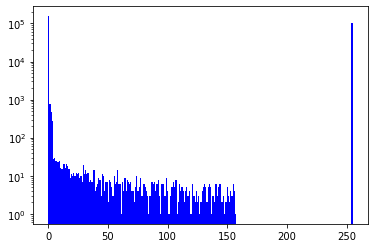

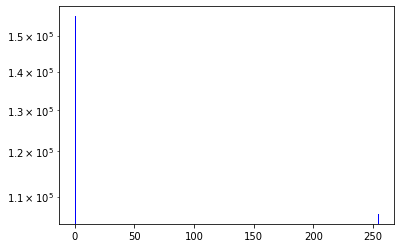

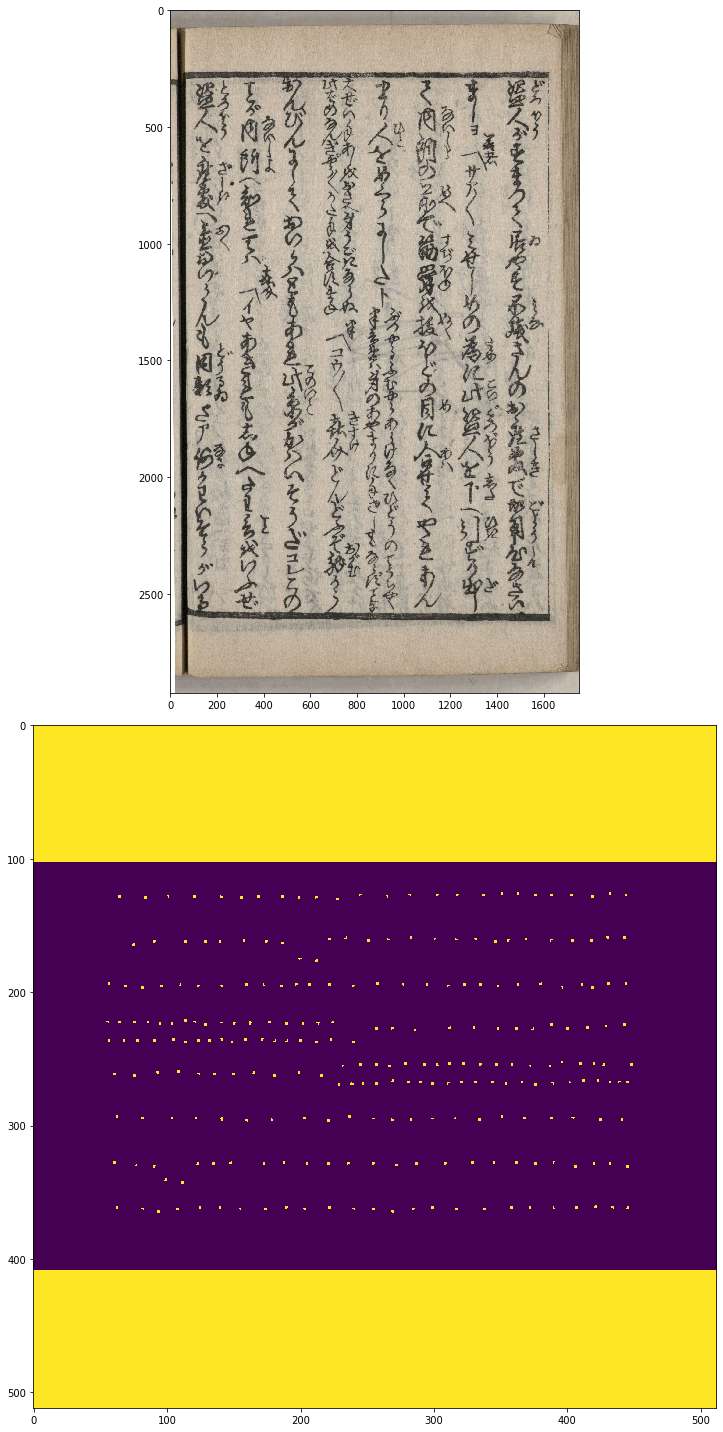

In [16]:
plt.hist(cSegMapCenter.flatten(), 256, facecolor='blue', True)
plt.show()
cSegMapCenter = np.where(cSegMapCenter<10, 0, 255)
plt.hist(cSegMapCenter.flatten(), 256, facecolor='blue', True)
plt.show()
fig, ax = plt.subplots(2,1, figsize=(20,20))
ax1, ax2 = ax.ravel()
ax1.imshow(Im)
ax2.imshow(cSegMapCenter)
plt.tight_layout()